In [1]:
library('xts')
library('ggplot2')
library('tseries')
#library('depmixS4')
library('gridExtra')
library('pinbasic')
set.seed(1)

Warning message:
"package 'xts' was built under R version 3.4.4"Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'tseries' was built under R version 3.4.4"Warning message:
"package 'gridExtra' was built under R version 3.4.4"Warning message:
"package 'pinbasic' was built under R version 3.4.4"

In [4]:
setwd('C:/Users/JEONG/Desktop/Trading')

In [6]:
BTCdata <- read.csv('BTCHdata2.csv')

In [7]:
time <- as.POSIXct(BTCdata$date,format = "%Y. %m. %d %H:%M:%S")
BTCDATA <- xts(BTCdata[,2:7],order.by=time)

In [8]:
BTCDATA$dP = diff(BTCDATA[,1])

In [9]:
BTCDATA$dPsd = NA
BTCDATA$k = NA
BTCDATA$bk = NA
BTCDATA$sk = NA
for (i in 1:length(BTCDATA[,1])){
    if (i>=81){
        #BTCDATA$dPsd[i] <- sd(BTCDATA$dP[(i-79):i])
        #BTCDATA$k[i] <- (log(sum(BTCDATA$volumeto[(i-2):i])))/sum((BTCDATA$dP[(i-2):i]))
        BTCDATA$k[i] <- (log(BTCDATA$volumeto[i]))/abs(BTCDATA$dP[i])
        #BTCDATA$bk[i] <- (log(BTCDATA$Buy[i]))/abs(BTCDATA$dP)
        #BTCDATA$sk[i] <- (log(BTCDATA$Sell[i]))/abs(BTCDATA$dP)
        BTCDATA$dPsd[i] <- sd(na.omit(BTCDATA$dP))
    }
}    

In [10]:
BTCDATA$Buy = NA
BTCDATA$Sell = NA
for (i in 1:length(BTCDATA[,1])){
    if (i>=81){ 
        if (as.integer(BTCDATA$volumeto[i]*pnorm(BTCDATA$dP[i]/BTCDATA$dPsd[i])/10000000) == 0){
            BTCDATA$Buy[i] <- 1
        }else {
            BTCDATA$Buy[i] <- abs(as.integer(BTCDATA$volumeto[i]*pnorm(BTCDATA$dP[i]/BTCDATA$dPsd[i])/10000000))
        }
    }
}

for (i in 1:length(BTCDATA[,1])){
    if (i>=81){
        if (as.integer((BTCDATA$volumeto[i]/10000000-BTCDATA$Buy[i]))==0){
            BTCDATA$Sell[i] <- 1
        }else{
            BTCDATA$Sell[i] <- abs(as.integer((BTCDATA$volumeto[i]/10000000-BTCDATA$Buy[i])))
        }
    }
}

In [11]:
for (i in 1:length(BTCDATA[,1])){
    if (i>=81){
        #BTCDATA$dPsd[i] <- sd(BTCDATA$dP[(i-79):i])
        #BTCDATA$k[i] <- (log(sum(BTCDATA$volumeto[(i-2):i])))/sum((BTCDATA$dP[(i-2):i]))
        #BTCDATA$k[i] <- (log(BTCDATA$volumeto[i]))/abs(BTCDATA$dP)
        BTCDATA$bk[i] <- (log(BTCDATA$Buy[i]))/abs(BTCDATA$high[i]-BTCDATA$low[i])
        BTCDATA$sk[i] <- (log(BTCDATA$Sell[i]))/abs(BTCDATA$low[i]-BTCDATA$high[i])
        #BTCDATA$dPsd[i] <- sd(na.omit(BTCDATA$dP))
    }
}     

In [12]:
BTCDATA$alpha = NA
BTCDATA$rdelta = NA
BTCDATA$epsilon_b = NA
BTCDATA$epsilon_s = NA
BTCDATA$mu = NA
BTCDATA$pin = NA

for (i in 1:2001){
    try(if (i>=160){
        ipin <- pin_est(numbuys = BTCDATA$Buy[(i-80+1):i], numsells = BTCDATA$Sell[(i-80+1):i], posterior = FALSE)
        
        BTCDATA$alpha[i] <- ipin$Results[1,1]
        BTCDATA$rdelta[i] <- (1-ipin$Results[2,1])
        BTCDATA$epsilon_b[i] <- ipin$Results[3,1]
        BTCDATA$epsilon_s[i] <- ipin$Results[4,1]
        BTCDATA$mu[i] <- ipin$Results[5,1]
        BTCDATA$pin[i] <- ipin$pin
    })
}

In [13]:
BTCDATA$upp = NA
BTCDATA$downp = NA

for (i in 1:2001){
    if (i>=160){
        BTCDATA$upp[i] = 0.5+0.5*BTCDATA$alpha[i]*(-1+2*BTCDATA$rdelta[i])
        BTCDATA$downp[i] = 1-BTCDATA$upp[i]
    }
}

Warning message:
"Removed 159 rows containing missing values (geom_path)."Warning message:
"Removed 159 rows containing missing values (geom_path)."Warning message:
"Removed 80 rows containing missing values (geom_path)."

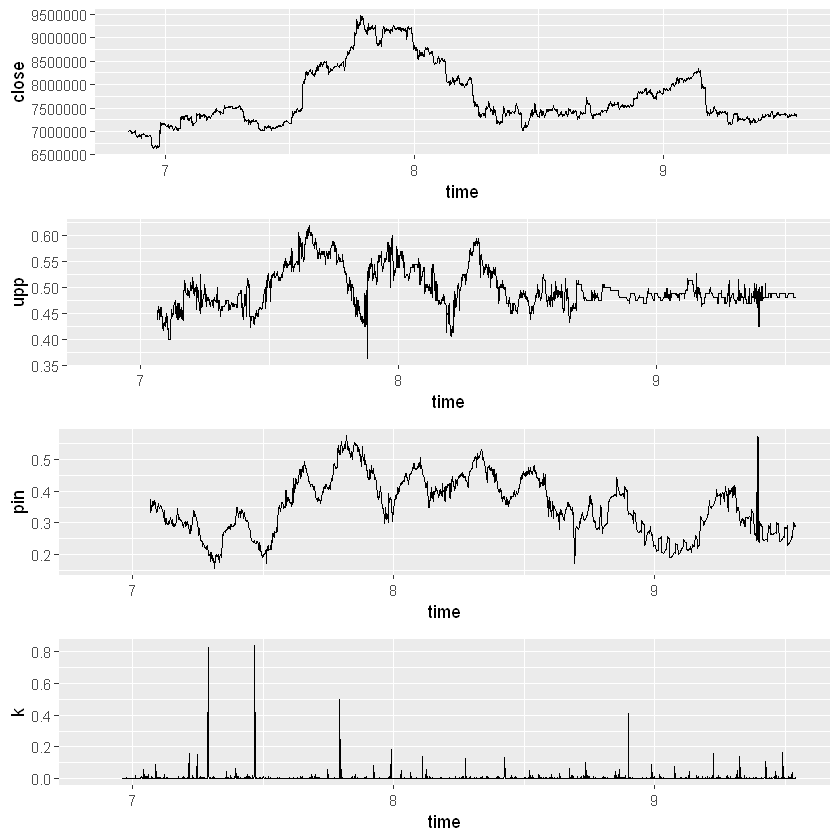

In [14]:
p1 = ggplot(BTCDATA, aes(x=time,y=upp),colour = 'blue') + geom_line()
p2 = ggplot(BTCDATA, aes(x=time,y=pin),colour = 'red') + geom_line()
p3 = ggplot(BTCDATA, aes(x=time,y=close),colour = 'red') + geom_line()
pk = ggplot(BTCDATA, aes(x=time,y=k))+geom_line()
grid.arrange(p3,p1,p2,pk,ncol=1)

In [15]:
mp = median(na.omit(BTCDATA$pin))
mk = median(na.omit(BTCDATA$k))

qk = (quantile(na.omit(BTCDATA$k)))
qkk = as.numeric(qk[2])
qkkk = as.numeric(qk[4])
qp = (quantile(na.omit(BTCDATA$pin)))
qpp = as.numeric(qp[4])

In [16]:
s = 0
n = 0
for (i in 160:2000){
    try(if (coredata(BTCDATA$upp[i])>0.5){
        n = n+1
    })
    
    try(if ((coredata(BTCDATA$close[(i+1)]) >= coredata(BTCDATA$close[i]))&&(coredata(BTCDATA$upp[i])> 0.5)){
        s = s+1
    })   
}
print(s)
print(n)
print(s/n)

[1] 320
[1] 629
[1] 0.508744


In [17]:
s = 0
n = 0
for (i in 160:2000){
    try(if (coredata(BTCDATA$upp[i])<0.5){
        n = n+1
    })
    
    try(if ((coredata(BTCDATA$close[(i+1)]) <= coredata(BTCDATA$close[i]))&&(coredata(BTCDATA$upp[i])< 0.5)){
        s = s+1
    })   
}
print(s)
print(n)
print(s/n)

[1] 594
[1] 1195
[1] 0.4970711


In [18]:
mp = median(na.omit(BTCDATA$pin))
mk = median(na.omit(BTCDATA$k))
qk = (quantile(na.omit(BTCDATA$k)))
qkk = as.numeric(qk[2])
qpp = (quantile(na.omit(BTCDATA$pin)))
qppp = as.numeric(qp[4])
qpppp = as.numeric(qp[2])

In [27]:
s = 0
n = 0
for (i in 160:2000){
    try(if ((coredata(BTCDATA$upp[i])>0.5)&&(coredata(BTCDATA$pin[i])<qppp)&&(coredata(BTCDATA$pin[i]>qpppp))
           &&(coredata(BTCDATA$bk[i])<0.8*coredata(BTCDATA$sk[i]))){
        n = n+1
    })
    
    try(if ((coredata(BTCDATA$close[(i+1)]) >= coredata(BTCDATA$close[i]))&&(coredata(BTCDATA$pin[i]>qpppp))
            &&(coredata(BTCDATA$upp[i])>0.5)
            &&(coredata(BTCDATA$pin[i]<qppp)&&(coredata(BTCDATA$bk[i])<0.8*coredata(BTCDATA$sk[i])))){
        s = s+1
    })   
}
print(s)
print(n)
print(s/n)

[1] 25
[1] 48
[1] 0.5208333


In [20]:
s = 0
n = 0
for (i in 160:2000){
    try(if ((coredata(BTCDATA$upp[i])>0.5)&&((coredata(BTCDATA$pin[i])<qpppp)||(coredata(BTCDATA$pin[i]>qppp)))
           &&(0.8*coredata(BTCDATA$bk[i])>coredata(BTCDATA$sk[i]))){
        n = n+1
    })
    
    try(if ((coredata(BTCDATA$close[(i+1)]) <= coredata(BTCDATA$close[i]))&&(coredata(BTCDATA$upp[i])>0.5)
            &&((coredata(BTCDATA$pin[i])<qpppp)||(coredata(BTCDATA$pin[i]>qppp)))
            &&(0.8*coredata(BTCDATA$bk[i])>coredata(BTCDATA$sk[i]))){
        s = s+1
    })   
}
print(s)
print(n)
print(s/n)

[1] 40
[1] 75
[1] 0.5333333


In [33]:
s = 0
n = 0
for (i in 160:2000){
    try(if ((coredata(BTCDATA$upp[i])<0.5)&&(coredata(BTCDATA$pin[i])<qppp)&&(coredata(BTCDATA$pin[i]>qpppp))
           &&(0.8*coredata(BTCDATA$bk[i])>coredata(BTCDATA$sk[i]))){
        n = n+1
    })
    
    try(if ((coredata(BTCDATA$close[(i+1)]) <= coredata(BTCDATA$close[i]))&&(coredata(BTCDATA$upp[i])<0.5)
            &&(coredata(BTCDATA$pin[i])<qppp)&&(coredata(BTCDATA$pin[i]>qpppp))
            &&(0.8*coredata(BTCDATA$bk[i])>coredata(BTCDATA$sk[i]))){
        s = s+1
    })   
}
print(s)
print(n)
print(s/n)

[1] 53
[1] 90
[1] 0.5888889


In [34]:
s = 0
n = 0
for (i in 160:2000){
    try(if ((coredata(BTCDATA$upp[i])<0.5)&&((coredata(BTCDATA$pin[i])<qpppp)||(coredata(BTCDATA$pin[i]>qppp)))
           &&(coredata(BTCDATA$bk[i])<0.8*coredata(BTCDATA$sk[i]))){
        n = n+1
    })
    
    try(if ((coredata(BTCDATA$close[(i+1)]) >= coredata(BTCDATA$close[i]))&&(coredata(BTCDATA$upp[i])<0.5)
            &&((coredata(BTCDATA$pin[i])<qpppp)||(coredata(BTCDATA$pin[i]>qppp)))
            &&(coredata(BTCDATA$bk[i])<0.8*coredata(BTCDATA$sk[i]))){
        s = s+1
    })   
}
print(s)
print(n)
print(s/n)

[1] 49
[1] 72
[1] 0.6805556


In [35]:
install.packages("", repos='http://cran.r-project.org')

package 'httr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\JEONG\AppData\Local\Temp\RtmpGqJfAj\downloaded_packages
